In [1]:
from dataset_creation import create_dataset

from utils import get_taxonomy_leaves, get_yamnet_classes

taxonomy_names, yamnet_names = get_taxonomy_leaves(), get_yamnet_classes()

dataset = create_dataset()
len(dataset)

2023-12-22 15:52:01.744163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 15:52:01.948262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-22 15:52:01.948302: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-22 15:52:03.129660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

216

In [2]:
embeddings = [el.get_yamnet_embeddings() for el in dataset]
embeddings[0].shape, embeddings[0]

2023-12-22 15:52:11.707049: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2023-12-22 15:52:12.985908: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2023-12-22 15:52:13.621344: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25559040 exceeds 10% of free system memory.
2023-12-22 15:52:14.125053: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2023-12-22 15:52:14.791757: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25952256 exceeds 10% of free system memory.
2023-12-22 15:52:15.845651: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.


(TensorShape([61, 1024]),
 <tf.Tensor: shape=(61, 1024), dtype=float32, numpy=
 array([[0.0000000e+00, 1.2737225e-01, 9.7548467e-04, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 3.0008632e-01, 1.0285262e-01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 1.1675718e-01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 1.0036316e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 5.1528674e-01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 1.6706948e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32)>)

In [3]:
labels = [el.labels_array for el in dataset]
len(labels), labels[0].shape

(216, (61, 30))

In [4]:
from utils import split_train_test

train_x, train_y, test_x, test_y = split_train_test(embeddings, labels)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

(TensorShape([6921, 1024]),
 TensorShape([6921, 30]),
 TensorShape([1625, 1024]),
 TensorShape([1625, 30]))

Let's look at the distribution of labels

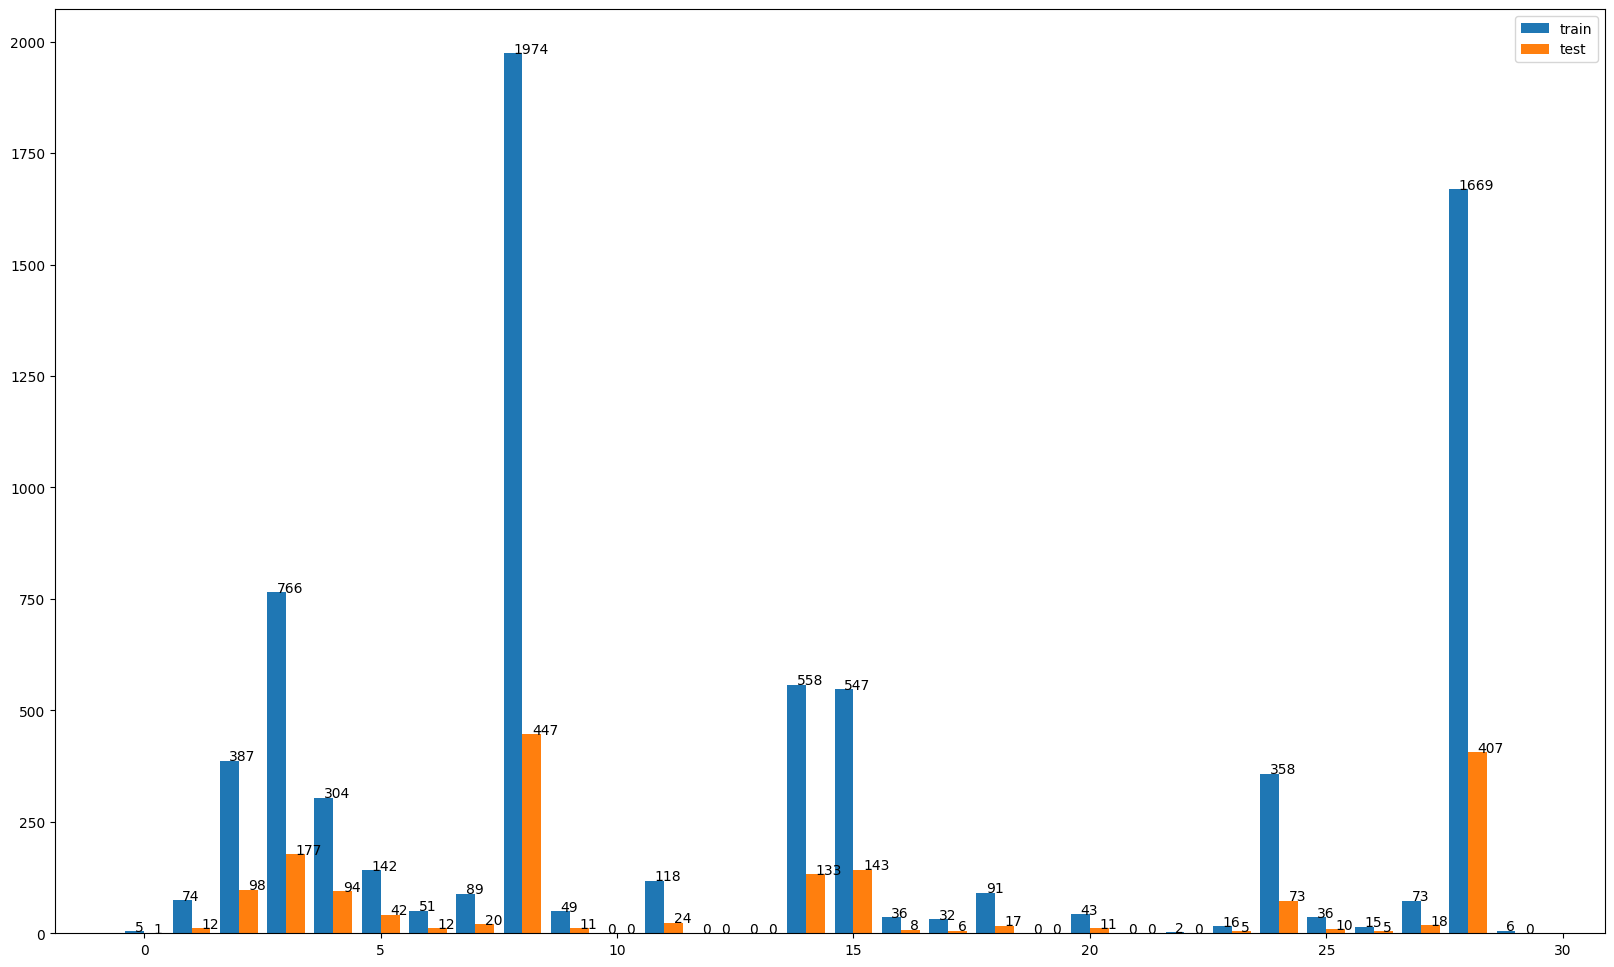

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

n_classes = int(train_y.shape[1])   # type: ignore

plt.figure(figsize=(20, 12))
xs = np.arange(n_classes)
train_bar = tf.reduce_sum(train_y, axis=0).numpy()
test_bar = tf.reduce_sum(test_y, axis=0).numpy()

plt.bar(xs - 0.2, train_bar, 0.4)
for i, x in enumerate(xs - 0.2):
    plt.text(x, train_bar[i], str(int(train_bar[i])))

plt.bar(xs + 0.2, test_bar, 0.4)
for i, x in enumerate(xs + 0.2):
    plt.text(x, test_bar[i], str(int(test_bar[i])))

plt.legend(['train', 'test'])
plt.show()

There are no classes present in the test and not in the training, so we can train a model

# Train the model

In [6]:
dropout_rate = 0.1
lr = 0.0005
patience = 10
hid_1, hid_2 = 1024, 512
epochs = 30 #100 30 should be enough

In [7]:
from keras import regularizers

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(hid_1, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(hid_2, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(n_classes, activation='sigmoid')#, bias_initializer=output_bias)
], name='model')
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=patience,
                                            restore_best_weights=True)

history = model.fit(train_x,
                    train_y,
                    epochs=epochs,
                    validation_data=(test_x, test_y),
                    callbacks=callback)


Epoch 1/30
217/217 [==============================] - 7s 29ms/step - loss: 0.3550 - val_loss: 0.1782
Epoch 2/30
217/217 [==============================] - 6s 30ms/step - loss: 0.1397 - val_loss: 0.1212
Epoch 3/30
217/217 [==============================] - 6s 29ms/step - loss: 0.1063 - val_loss: 0.1032
Epoch 4/30
217/217 [==============================] - 7s 31ms/step - loss: 0.0928 - val_loss: 0.0965
Epoch 5/30
217/217 [==============================] - 6s 27ms/step - loss: 0.0854 - val_loss: 0.0883
Epoch 6/30
217/217 [==============================] - 6s 26ms/step - loss: 0.0807 - val_loss: 0.0854
Epoch 7/30
217/217 [==============================] - 6s 27ms/step - loss: 0.0773 - val_loss: 0.0829
Epoch 8/30
217/217 [==============================] - 6s 26ms/step - loss: 0.0746 - val_loss: 0.0805
Epoch 9/30
217/217 [==============================] - 6s 26ms/step - loss: 0.0726 - val_loss: 0.0805
Epoch 10/30
217/217 [==============================] - 6s 27ms/step - loss: 0.0708 - val_lo

In [8]:
pred_y = model.predict(test_x)

51/51 [==============================] - 0s 6ms/step


# Model evaluation

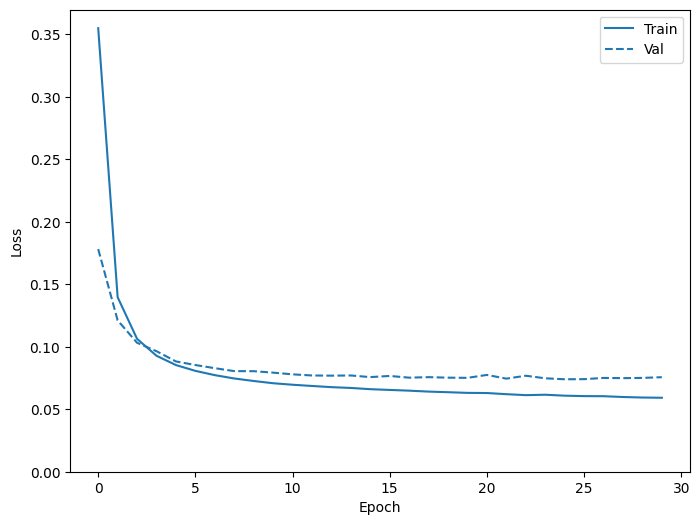

In [9]:
from evaluate import plot_history

plot_history(history)

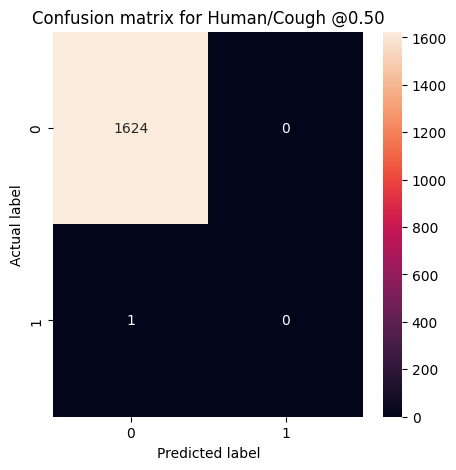

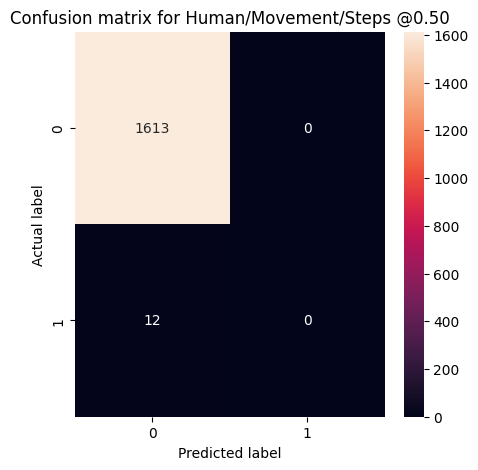

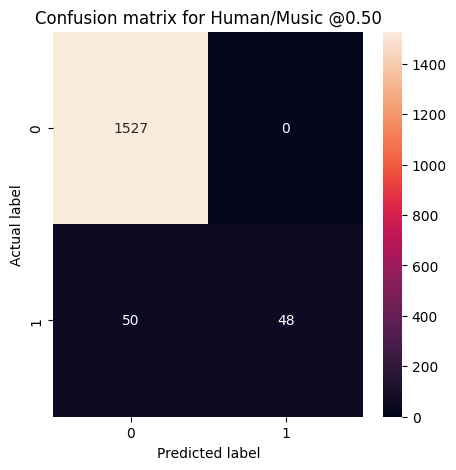

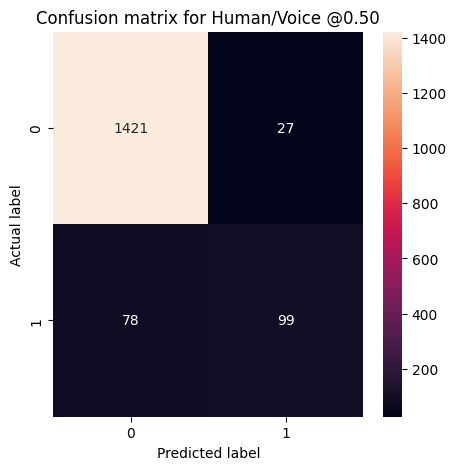

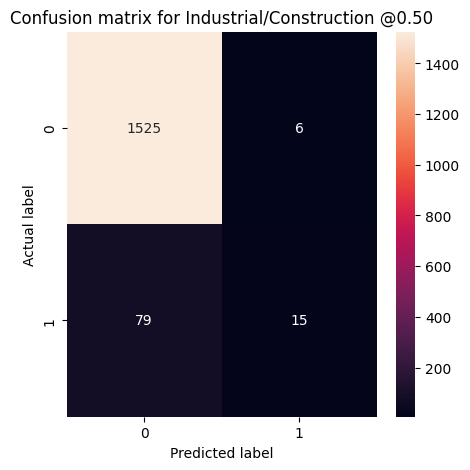

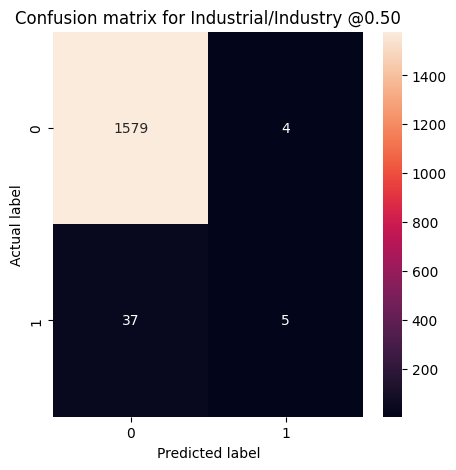

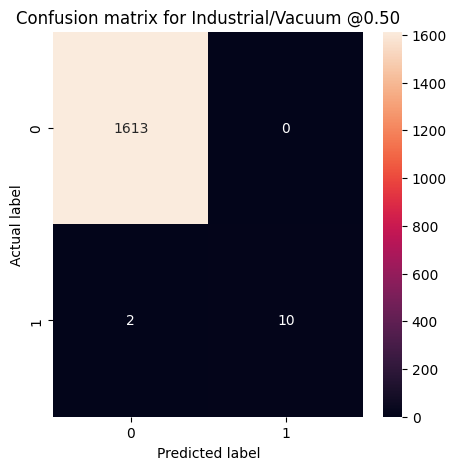

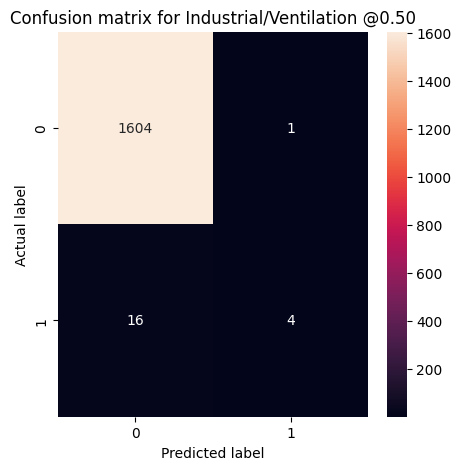

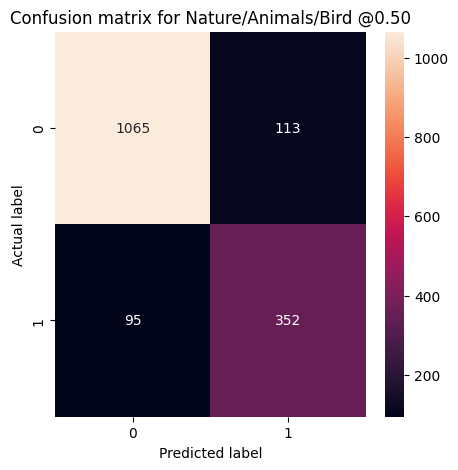

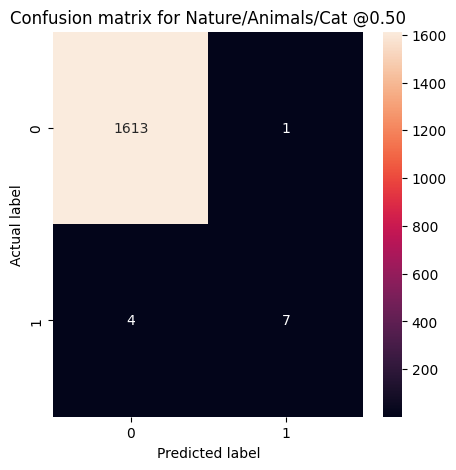

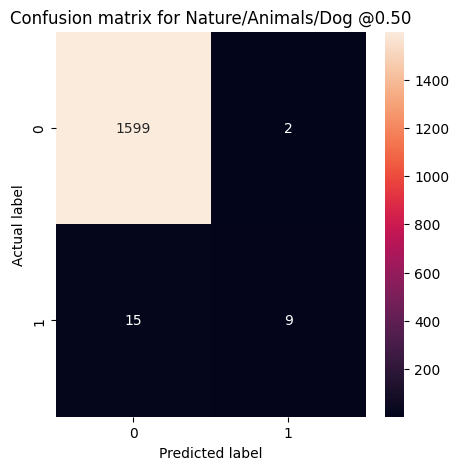

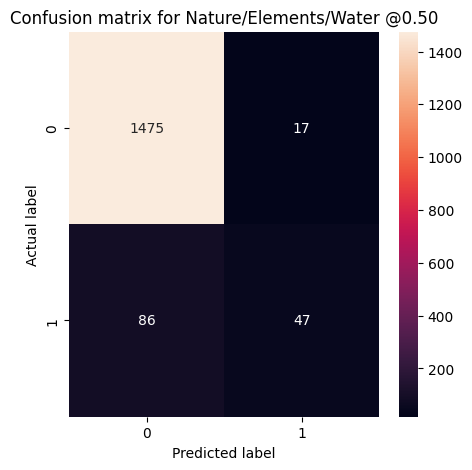

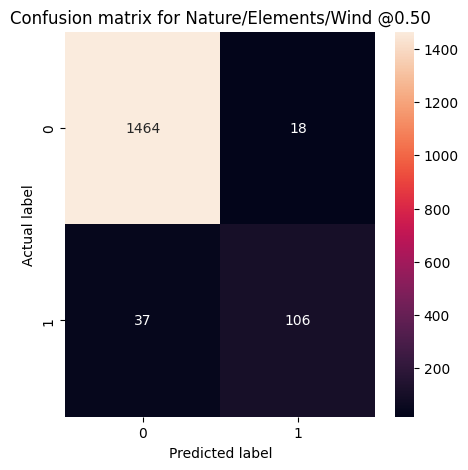

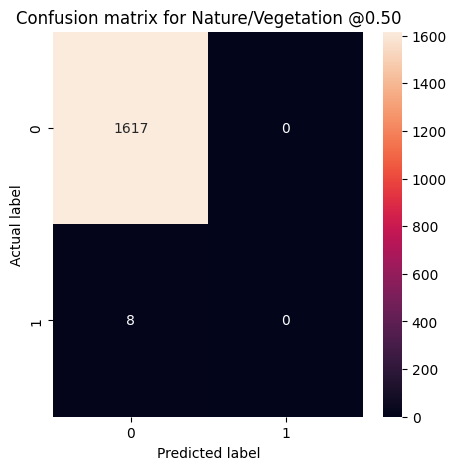

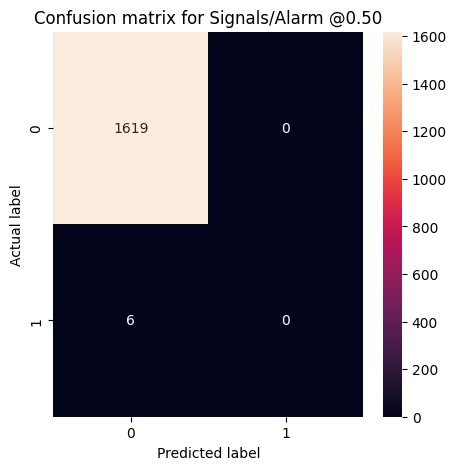

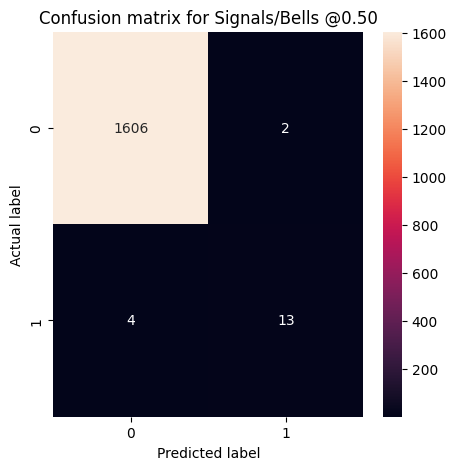

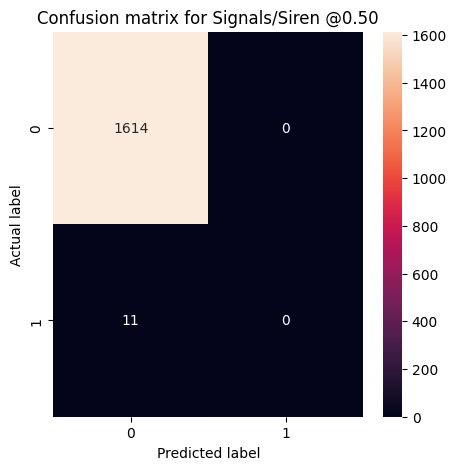

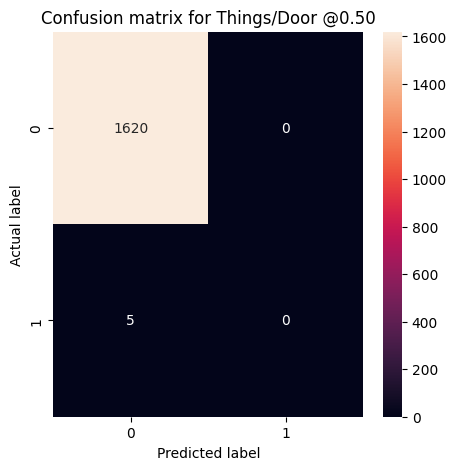

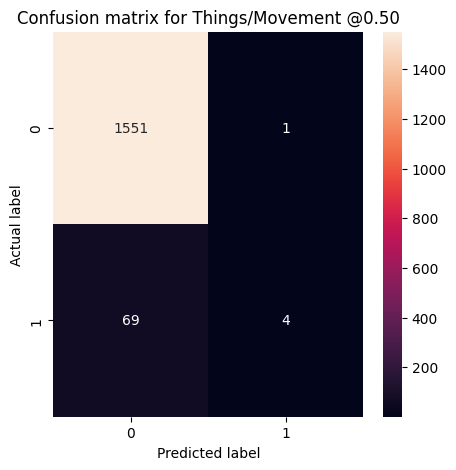

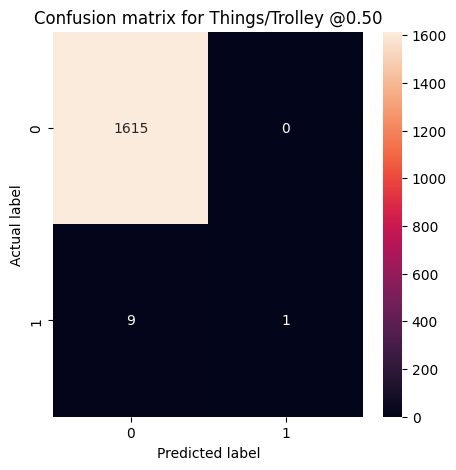

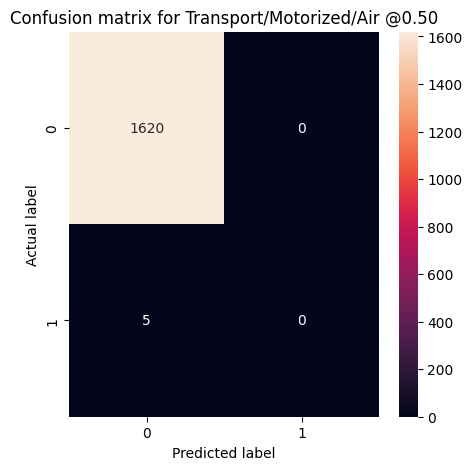

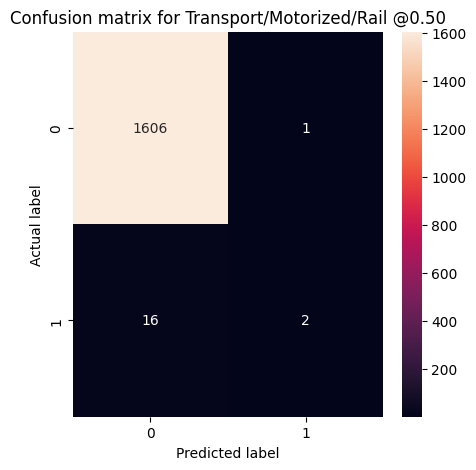

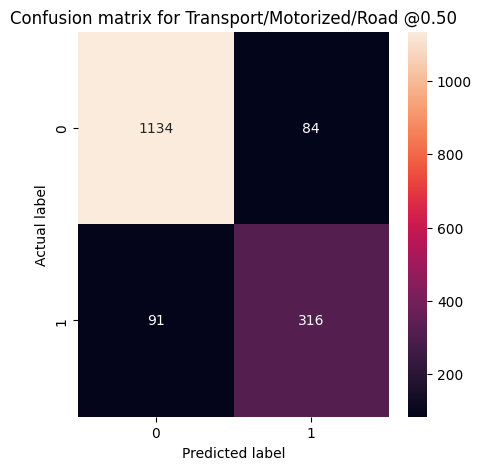

Metrics:
	accuracy: 0.5551
	balanced_accuracy: 0.7307
	precision_macro: 0.4339
	recall_macro: 0.2354
	f1_macro: 0.2787
	precision_micro: 0.7894
	recall_micro: 0.5851
	f1_micro: 0.6721
Per-class metrics:
	Human/Cough:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Human/Movement/Steps:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Human/Music:
		precision: 1.0000
		recall: 0.4898
		f1: 0.6575
	Human/Voice:
		precision: 0.7857
		recall: 0.5593
		f1: 0.6535
	Industrial/Construction:
		precision: 0.7143
		recall: 0.1596
		f1: 0.2609
	Industrial/Industry:
		precision: 0.5556
		recall: 0.1190
		f1: 0.1961
	Industrial/Vacuum:
		precision: 1.0000
		recall: 0.8333
		f1: 0.9091
	Industrial/Ventilation:
		precision: 0.8000
		recall: 0.2000
		f1: 0.3200
	Nature/Animals/Bird:
		precision: 0.7570
		recall: 0.7875
		f1: 0.7719
	Nature/Animals/Cat:
		precision: 0.8750
		recall: 0.6364
		f1: 0.7368
	Nature/Animals/Cricket:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Nature/Animals/Dog:


In [10]:
from evaluate import evaluate

evaluate(test_y, pred_y, threshold=0.5)

In [11]:
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print(f"Threshold: {threshold}")
    evaluate(test_y, pred_y, threshold=threshold, plot_confusion_matrices=False)

Threshold: 0.1
Metrics:
	accuracy: 0.3889
	balanced_accuracy: 0.8086
	precision_macro: 0.2901
	recall_macro: 0.4211
	f1_macro: 0.3282
	precision_micro: 0.4889
	recall_micro: 0.8157
	f1_micro: 0.6113
Per-class metrics:
	Human/Cough:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Human/Movement/Steps:
		precision: 0.0625
		recall: 0.0833
		f1: 0.0714
	Human/Music:
		precision: 0.8261
		recall: 0.7755
		f1: 0.8000
	Human/Voice:
		precision: 0.4951
		recall: 0.8588
		f1: 0.6281
	Industrial/Construction:
		precision: 0.4675
		recall: 0.3830
		f1: 0.4211
	Industrial/Industry:
		precision: 0.2603
		recall: 0.4524
		f1: 0.3304
	Industrial/Vacuum:
		precision: 0.8000
		recall: 1.0000
		f1: 0.8889
	Industrial/Ventilation:
		precision: 0.1702
		recall: 0.4000
		f1: 0.2388
	Nature/Animals/Bird:
		precision: 0.5286
		recall: 0.9508
		f1: 0.6795
	Nature/Animals/Cat:
		precision: 0.6154
		recall: 0.7273
		f1: 0.6667
	Nature/Animals/Cricket:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Natur

# Save the model

In [12]:
model.save("ml_models/fine_tuned_model.keras")